In [1]:
#We import the necessary libraries here
import astropy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import optimize
import sympy
sympy.init_printing()
import emcee
import corner
plt.rcParams.update({'font.size': 16, 'text.usetex': True})

# Loading the 3 datasets from the OGLE website

In [2]:
#We initialize the datasets

dat1 = np.loadtxt('blg-1307/phot.dat', usecols = (0,1,2))
dat2 = np.loadtxt('blg-0164/phot.dat', usecols = (0,1,2))
dat3 = np.loadtxt('blg-0148/phot.dat', usecols = (0,1,2))

# Assigning the Time, Magnitude, and Magnitude Error Parameters as the first three columns in our datasets

HJD_1, I_1, MagErr_1 = np.hsplit(dat1, 3)
HJD_2, I_2, MagErr_2 = np.hsplit(dat2, 3)
HJD_3, I_3, MagErr_3 = np.hsplit(dat3, 3)


# Defining the parameters for the Model:

The time when the magnitude peaked: $\space t_0$ $\newline{}$
Blending Ratio: $\space f_{bl}$$\newline{}$
Base Magnitude:$\space m_{src}$$\newline{}$
Minimum Value of u:$\space \space u_{min}$$\newline{}$
Event Time Scale:$ \space t_{E}$$\newline{}$

[2458737.65896]


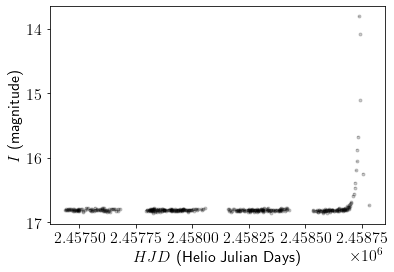

In [3]:
#constant definitions

t0_1 = HJD_1[np.where(I_1 == np.min(I_1))]
t0_2 = HJD_2[np.where(I_2 == np.min(I_2))]
t0_3 = HJD_3[np.where(I_3 == np.min(I_3))]

#print(True) if (HJD_1[np.where(I_1 == np.min(I_1))] == t0_1) else print(False) #works fine


#all these subsequent values are taken from the OGLE website

fbl_1 = 0.885
fbl_2 = 1.00
fbl_3 = 1.00 

m0_1 = 16.811
m0_2 = 18.814
m0_3 = 13.403

umin_1 = 0.047
umin_2 = 0.118
umin_3 = 0.279

tE_1 = 23.127
tE_2 = 6.236
tE_3 = 58.205

plt.errorbar(HJD_1, I_1, yerr = MagErr_1.flatten(), fmt = '.', color='black', ecolor='black', alpha=0.2)
plt.ylim(plt.ylim()[::-1])
plt.xlabel(r'$HJD$ (Helio Julian Days)')
plt.ylabel(r'$I$ (magnitude)')
plt.savefig('2019-BLG-1307_Original_Data.png')

print(t0_1)

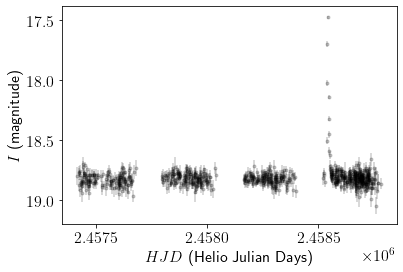

In [4]:
plt.errorbar(HJD_2, I_2, yerr = MagErr_2.flatten(), fmt = '.', color='black', ecolor='black', alpha=0.2)
plt.ylim(plt.ylim()[::-1])
plt.xlabel(r'$HJD$ (Helio Julian Days)')
plt.ylabel(r'$I$ (magnitude)')
plt.savefig('2019-BLG-0164_Original_Data.png')

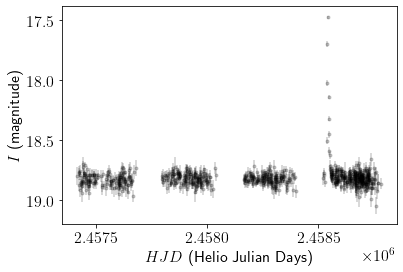

In [5]:
plt.errorbar(HJD_2, I_2, yerr = MagErr_2.flatten(), fmt = '.', color='black', ecolor='black', alpha=0.2)
plt.ylim(plt.ylim()[::-1])
plt.xlabel(r'$HJD$ (Helio Julian Days)')
plt.ylabel(r'$I$ (magnitude)')
plt.savefig('2019-BLG-148_Original_Data.png')


# Defining the Model and Chisq Functions

In [6]:
#Defining the Paczynski Function
def model(t, m0, fbl, t0, tE, umin):
    u = np.sqrt((umin**2) + ((t - t0)/tE)**2)
    A = (u**2 + 2) / (u*np.sqrt(u**2 + 4))
    return m0 - 2.5*np.log10(fbl*A + (1 - fbl))

#Defining the Penalty Function
def chisq(param, x, y, sigma):
    tpeak, fbl, m0, umin, tau = param
    return np.sum(((model(x, m0, fbl, tpeak, tau, umin) - y)**2)/sigma**2)

#Define the likelihood, prior and the probabilty functions 
def lnlike(param, x, y, sigma):
    return -0.5*chisq(param, x, y, sigma)

def lnprior(param):
    tpeak, fbl, m0, umin, tau = param
    if 0 < fbl < 1:
        return 0.0
    return -np.inf

def lnprob(param, x, y, sigma):
    lp = lnprior(param)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(param, x, y, sigma)


# Defining the MCMC Function

In [7]:
def mcmc(par):
    pstart = par
    p0 = np.array([pstart+1.0e-4*np.random.normal(size=ndim) for iwalk in range(nwalk)])
    sampler = emcee.EnsembleSampler(nwalk,ndim,lnprob, args=(x, y, sigma))
    print('burn-in-run')
    pos, prob, state = sampler.run_mcmc(p0,nburn)
    sampler.reset()
    print('main-run')
    res = sampler.run_mcmc(pos,nmain)
    samples = sampler.chain.reshape((-1,ndim))
    return samples, sampler 

# Defining the MCMC Plot Function


In [8]:
def mcmc_plotter(sampler):
    labels = [r'$t_{0}$',r'$f_{bl}$',r'$m_{src}$', r'$u_{min}$', r'$t_{E}$']
    f,ax = plt.subplots(ndim,1,figsize=(10,10))
    for idim in range(ndim):
        for iwalk in range(nwalk):
            ax[idim].plot(sampler.chain[iwalk,:,idim])
        ax[idim].set_xlabel('step')
        ax[idim].set_ylabel(labels[idim])
    f.tight_layout()


# Dataset 1: OGLE 1307 

## Plotting the Model Function and Residuals Plot


In [9]:
opt1 = optimize.fmin(chisq,[t0_1, fbl_1, m0_1, umin_1, tE_1],args = (HJD_1,I_1,MagErr_1))

Optimization terminated successfully.
         Current function value: 989.861542
         Iterations: 289
         Function evaluations: 537


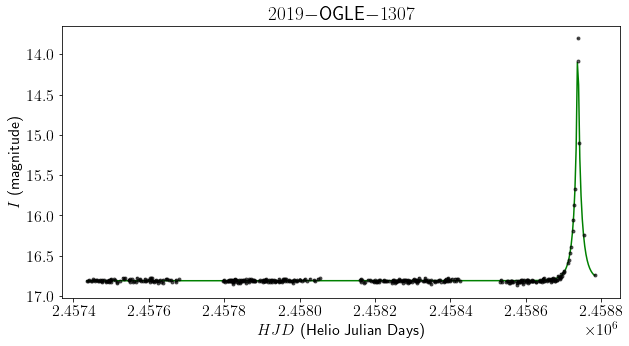

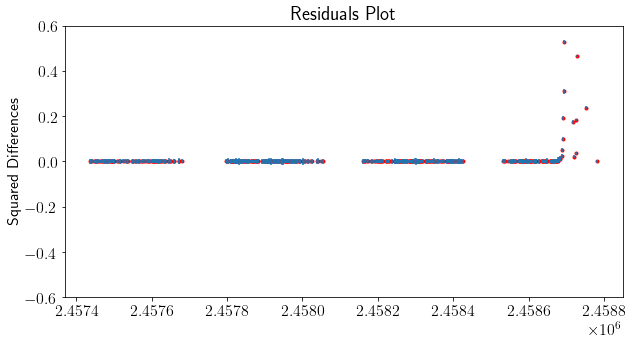

In [22]:
#Plot the data points, and the fitted model
t1 = np.linspace(np.min(HJD_1), np.max(HJD_1), HJD_1.size)
plt.figure(figsize = (10,5))
plt.errorbar(HJD_1, I_1, yerr = MagErr_1.flatten(), fmt = '.', color='black', ecolor='black', alpha=0.6)
plt.plot(t1, model(t1, opt1[2], opt1[1], opt1[0], opt1[4], opt1[3]), color='green')
plt.ylim(plt.ylim()[::-1]) #inverts y axis
plt.xlabel(r'$HJD$ (Helio Julian Days)')
plt.ylabel(r'$I$ (magnitude)')
plt.title(r'$2019 - $OGLE$ - 1307$')
plt.savefig('2019-BLG-1307_Original_Data.png', dpi=150)

#Plot the Residual
plt.figure(figsize = (10,5))
residual1 = (I_1[:,0] - model(t1, opt1[2], opt1[1], opt1[0], opt1[4], opt1[3]))**2
plt.scatter(HJD_1, residual1, color = 'r', marker = '.')
plt.errorbar(HJD_1, residual1, yerr = MagErr_1[:,0], ls = 'none')
plt.ylim(-0.6, 0.6)
plt.title('Residuals Plot')
plt.ylabel('Squared Differences')
plt.savefig('2019-BLG-1307_Residuals.png', dpi=150)

In [11]:
x, y, sigma, nwalk, nburn, nmain, ndim, plab= HJD_1, I_1, MagErr_1,20, 400, 2000, 5, [r'$t_{0}$',r'$f_{bl}$',r'$m_{src}$', r'$u_{min}$', r'$t_{E}$']
par_1 = np.array([opt1[0], opt1[1], opt1[2], opt1[3], opt1[4]], dtype=float) #init guesses for data1

## Plotting the Walkers and Generating the Corner Plot


burn-in-run
main-run


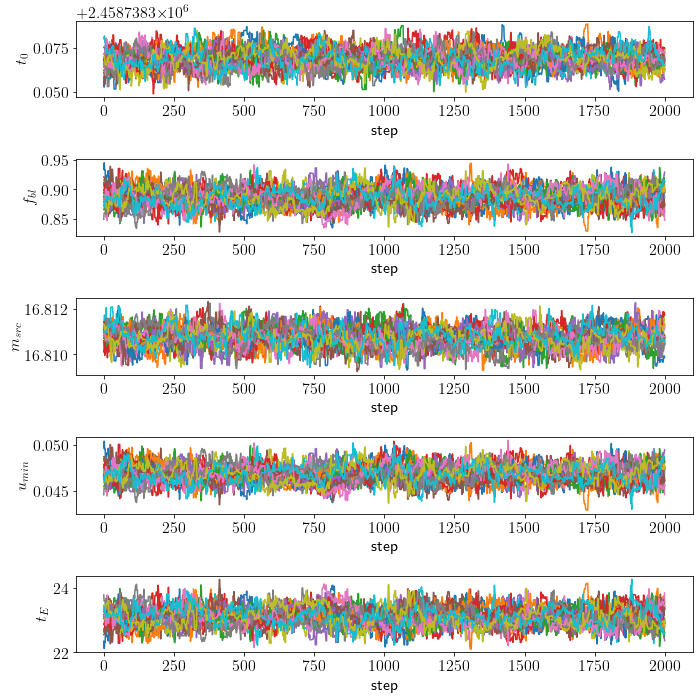

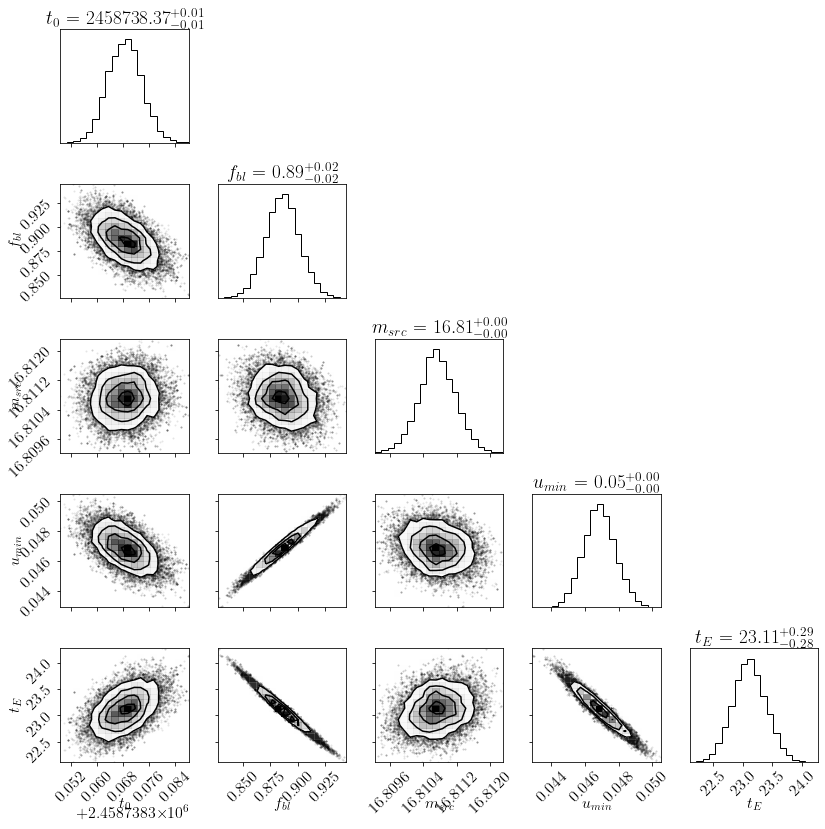

In [12]:
samples1, sampler1 = mcmc(par_1)
mcmc_plotter(sampler1)
f = corner.corner(samples1,show_titles=True,labels=plab)
f.tight_layout()

# Dataset 2: OGLE 0164

## Plotting the Model Function and Residuals Plot

In [13]:
opt2 = optimize.fmin(chisq,[t0_2, fbl_2, m0_2, umin_2, tE_2],args = (HJD_2,I_2,MagErr_2))
opt2

print(opt2[0])
print(opt2[1])
print(opt2[2])
print(opt2[3])
print(opt2[4])

Optimization terminated successfully.
         Current function value: 819.508336
         Iterations: 112
         Function evaluations: 267
2458543.110736993
0.9999881250615852
18.813999604801985
0.12389317176893913
6.23621315381916


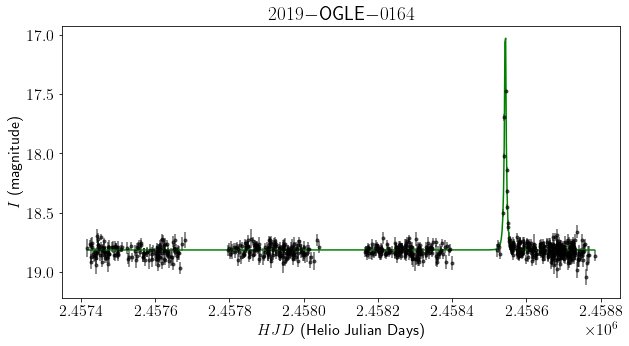

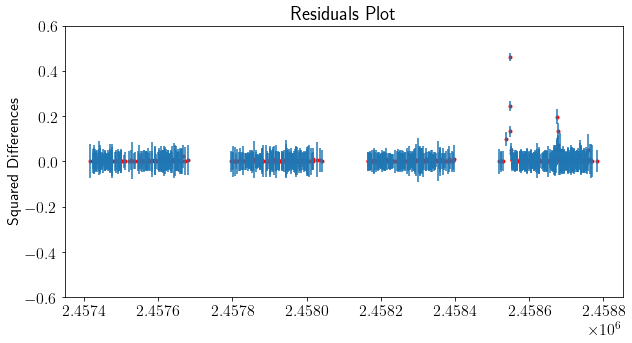

In [14]:
#Plot the data points, and the fitted model
t2 = np.linspace(np.min(HJD_2), np.max(HJD_2), HJD_2.size)
plt.figure(figsize = (10,5))
plt.errorbar(HJD_2, I_2, yerr = MagErr_2.flatten(), fmt = '.', color='black', ecolor='black', alpha=0.6)
plt.plot(t2, model(t2, opt2[2], opt2[1], opt2[0], opt2[4], opt2[3]), color='green')
plt.ylim(plt.ylim()[::-1]) #inverts y axis
plt.xlabel(r'$HJD$ (Helio Julian Days)')
plt.ylabel(r'$I$ (magnitude)')
plt.title(r'$2019 - $OGLE$ - 0164$')
plt.savefig('2019-BLG-0164_Original_Data.png', dpi=150)


#Plot the Residual
plt.figure(figsize = (10,5))
residual2 = (I_2[:,0] - model(t2, opt2[2], opt2[1], opt2[0], opt2[4], opt2[3]))**2
plt.scatter(HJD_2, residual2, color = 'r', alpha = 1, marker = '.')
plt.errorbar(HJD_2, residual2, yerr = MagErr_2[:,0], ls = 'none')
plt.ylim(-0.6, 0.6)
plt.title('Residuals Plot')
plt.ylabel('Squared Differences')
plt.savefig('2019-BLG-0164_Residuals.png', dpi=150)

## Defining the Parameters for the mcmc Function


In [15]:
x, y, sigma, nwalk, nburn, nmain, ndim, plab= HJD_2, I_2, MagErr_2,20, 400, 2000, 5, [r'$t_{0}$',r'$f_{bl}$',r'$m_{src}$', r'$u_{min}$', r'$t_{E}$']
par_2 = np.array([opt2[0], opt2[1], opt2[2], opt2[3], opt2[4]], dtype=float) #init guesses for data1

## Plot the walkers and generate the corner plot


burn-in-run


C:\Users\gp\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


main-run


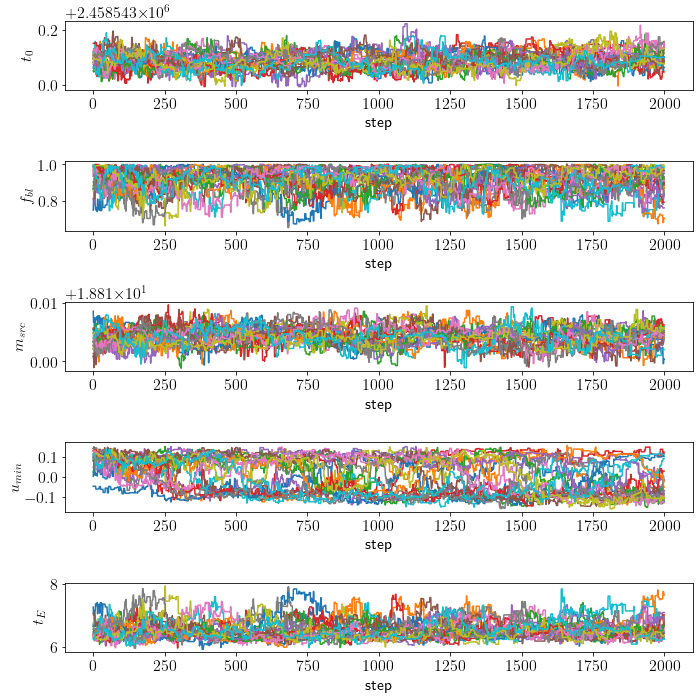

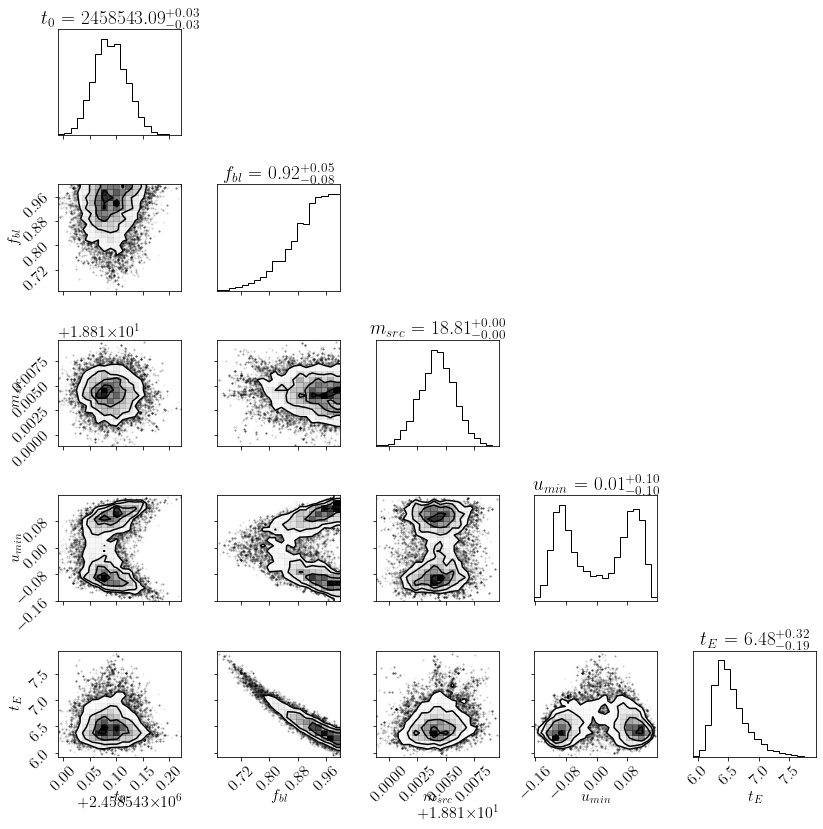

In [16]:
samples2, sampler2 = mcmc(par_2)
mcmc_plotter(sampler2)
f = corner.corner(samples2,show_titles=True,labels=plab)
f.tight_layout()



# Dataset 3: OGLE 0148




## Plotting the Model Function and Residuals Plot


In [17]:
opt3 = optimize.fmin(chisq,[t0_3, fbl_3, m0_3, umin_3, tE_3],args = (HJD_3,I_3,MagErr_3))

Optimization terminated successfully.
         Current function value: 52367.918015
         Iterations: 419
         Function evaluations: 726


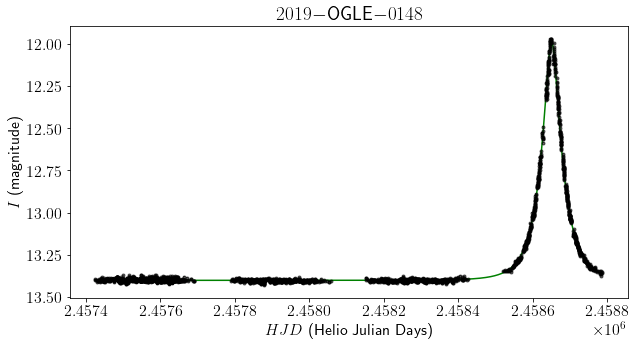

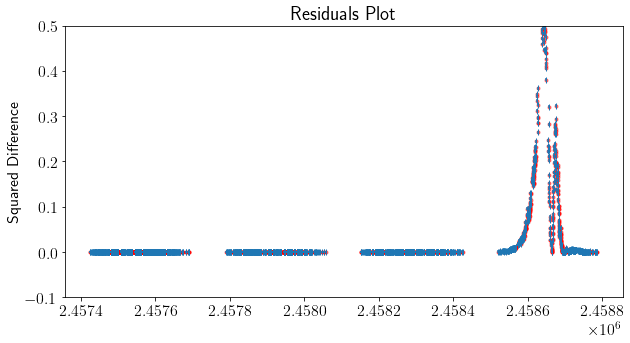

In [18]:
#Plot the data points, and the fitted model 
t3 = np.linspace(np.min(HJD_3), np.max(HJD_3), HJD_3.size)
plt.figure(figsize = (10,5))
plt.errorbar(HJD_3, I_3, yerr = MagErr_3.flatten(), fmt = '.', color='black', ecolor='black', alpha=0.6)
plt.plot(t3, model(t3, opt3[2], opt3[1], opt3[0], opt3[4], opt3[3]), color='green')
plt.ylim(plt.ylim()[::-1]) #inverts y axis
plt.xlabel(r'$HJD$ (Helio Julian Days)')
plt.ylabel(r'$I$ (magnitude)')
plt.title(r'$2019 - $OGLE$ - 0148$')
plt.savefig('2019-BLG-0148_Original_Data.png', dpi=150)


#Plot the Residual
plt.figure(figsize = (10,5))
residual3 = (I_3[:,0] - model(t3, opt3[2], opt3[1], opt3[0], opt3[4], opt3[3]))**2
plt.scatter(HJD_3, residual3,marker = '.',  color = 'r', alpha = 0.5)
plt.errorbar(HJD_3, residual3, yerr = MagErr_3[:,0], ls = 'none', marker = '|')
plt.ylim(-0.1, 0.5)
plt.title('Residuals Plot')
plt.ylabel('Squared Difference')
plt.savefig('2019-BLG-0148_Residuals.png', dpi=150)

## Defining the Parameters for the mcmc Function


In [19]:
x, y, sigma, nwalk, nburn, nmain, ndim, plab= HJD_3, I_3, MagErr_3,20, 400, 2000, 5, [r'$t_{0}$',r'$f_{bl}$',r'$m_{src}$', r'$u_{min}$', r'$t_{E}$']
par_3 = np.array([opt3[0], opt3[1], opt3[2], opt3[3], opt3[4]], dtype=float) #init guesses for data1

## Plot the walkers and generate the corner plot


burn-in-run
main-run


C:\Users\gp\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


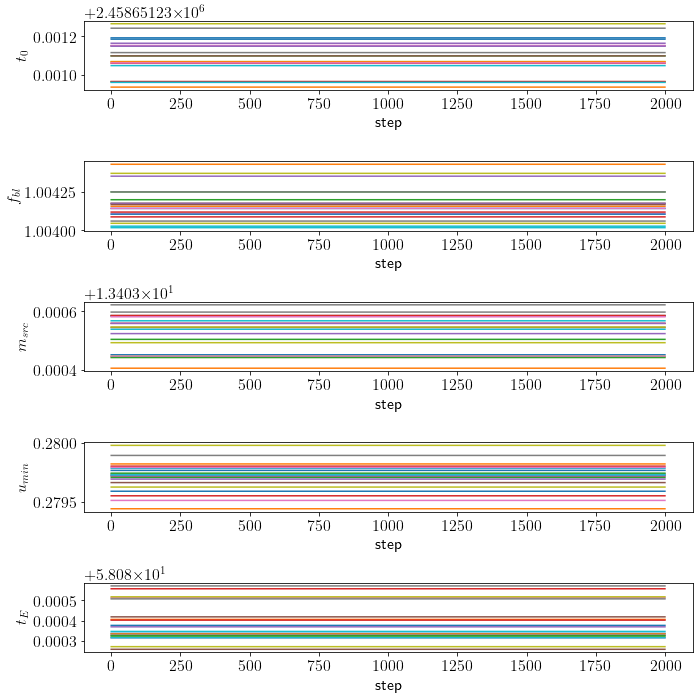

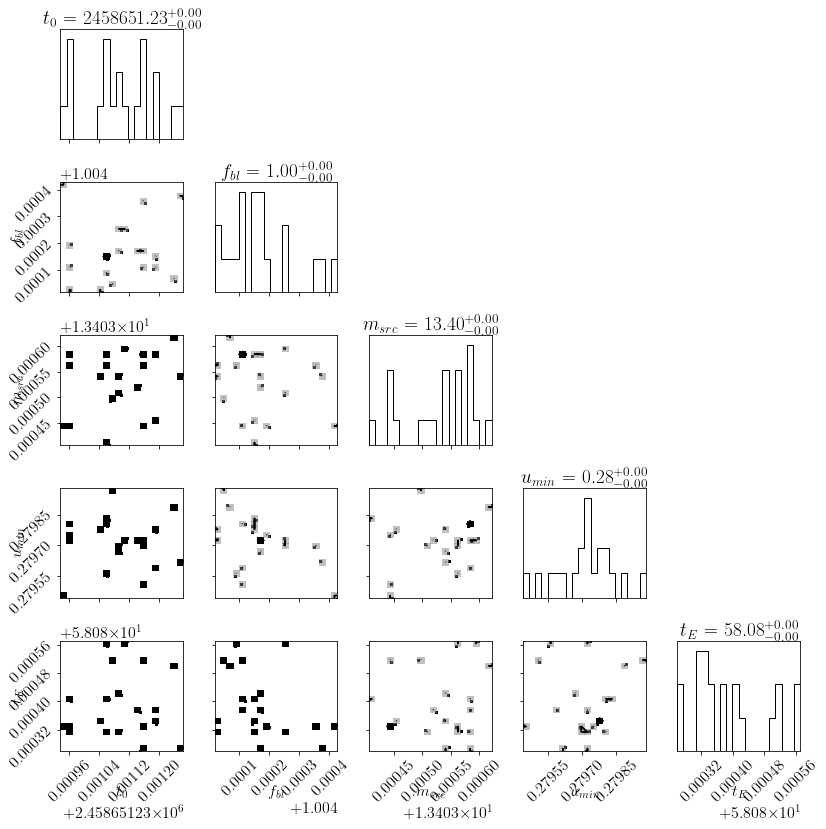

In [20]:
# Plot the walkers and generate the corner plot
samples3, sampler3 = mcmc(par_3)
mcmc_plotter(sampler3)
f = corner.corner(samples3,show_titles=True,labels=plab)
f.tight_layout()

## All Models Analysis

Here we use all the models and fit the data. This analysis is trivial since the alternate models are very close to the optimized model. To prove that this is the case we only consider BLG-0164, which is the messiest data set. 

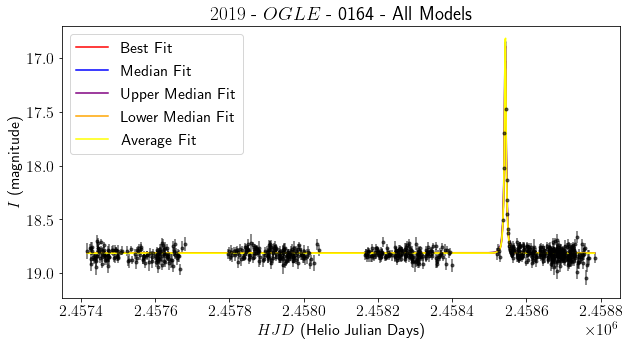

In [21]:
samples = sampler2.get_chain(flat=True)
t02_avg = np.mean(samples[:,0])
fbl2_avg = np.mean(samples[:,1])
m02_avg = np.mean(samples[:,2])
umin2_avg = np.mean(samples[:,3])
tE2_avg = np.mean(samples[:,4])

plt.figure(figsize = (10,5))
plt.errorbar(HJD_2, I_2, yerr = MagErr_2.flatten(), fmt = '.', color='black', ecolor='black', alpha=0.6)
plt.plot(t2, model(t2, opt2[2], opt2[1], opt2[0], opt2[4], opt2[3]), color='red', label = 'Best Fit')
plt.plot(t2, model(t2, 18.81, 0.92, 2458543.09, 6.48, 0.04), color='blue', label = 'Median Fit')
plt.plot(t2, model(t2, 18.81, 0.92 + 0.06, 2458543.09 + 0.03, 6.48 + 0.36, 0.04 + 0.06), color='purple', label = 'Upper Median Fit')
plt.plot(t2, model(t2, 18.81, 0.92 - 0.09, 2458543.09 - 0.03, 6.48 - 0.2, 0.04 - 0.13), color='orange', label = 'Lower Median Fit')
plt.plot(t2, model(t2, m02_avg, fbl2_avg, t02_avg, tE2_avg, umin2_avg), color='yellow', label = 'Average Fit')
plt.ylim(plt.ylim()[::-1]) #inverts y axis
plt.xlabel(r'$HJD$ (Helio Julian Days)')
plt.ylabel(r'$I$ (magnitude)')
plt.title(r'$2019$ - $OGLE$ - 0164 - All Models')
plt.legend()